# To study BNS lensing rate at varing $D_{hor}$
* $D_{hor}$ averaged over orientation and sky location will be considered 

In [1]:
import numpy as np
import bilby
import pylab as plt
from matplotlib import pyplot
import pycbc
from pycbc.detector import Detector
from datetime import datetime
from scipy.integrate import quad 

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [2]:
# for redshift to luminosity distance conversion
from astropy.cosmology import Planck18
from astropy.cosmology import z_at_value
import astropy.units as u

# BNS horizon range
* distance in units of Mpc upto which LIGO detector will be able to detect BNS with SNR>8
* with O3 (L1) sensitivity: $D_{hor}$=189.28 Mpc
* but here it will be a variable

# boolean function for detectable BNS
* $$Bool\text{_}D_{hor} = \left\{\int_{2}^{\infty}\Theta[D_l<D_{hor}(\mu,z)] P(\mu) d\mu \right\}$$
* Probability desity function of lens amplification: P(\mu)

In [3]:
def Bool_lensed(z, dhor_ori):
    
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value
    # find BNS horizon
    # considering only L1
    # scaling due to red-shifted chirp mass
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * (1+z)**(5/6) / (1+z_ori)**(5/6)

    if(Dl/dhor<=np.sqrt(2)):
        bool_lens = 1.
    else:
        bool_lens = 4.*(dhor/Dl)**4
    
    return(bool_lens)

# BBH/BNS merger rate

* merger rate as given in https://arxiv.org/abs/2204.12977: $ R(z,m) = R_0 g(z) f(m) \rho^{-1}$
* since we are considering only distance, mass pdf will integarte out to 1.
* therefore, $ R(z,m) = R_0 g(z) \rho^{-1}$
* z: redshift
* $\rho$: model dependent parameter
* $R_0$: local mereger rate of BNS, $13<R_0<1900$ $Gpc^{-3} yr^{-1}$
* $m_1=m_2=m$
* $$f(m)=\frac{m_{max}^{1+\gamma}-m_{min}^{1+\gamma}}{1+\gamma}$$
* $$ g(z)=C(1+z)^{\alpha}\left[ 1+\left( \frac{1+z}{1+z_p} \right)^{\alpha+\beta} \right]$$
* $\rho=1,\alpha=2.7,\beta=2.9,z_p=1.9,\gamma=0,m_{min}=1,m_{max}=2.5$ for baseline model of BNS.

In [5]:
def g_(z,a,b,zp):
    C = 1+(1+zp)**(-a-b) # ensures that g(z=0) = 1
    
    return( C*(1+z)**a * ( 1 + ((1+z)/(1+zp))**(a+b) )**(-1) )

# the value of local merger density rate R0 doesnt matter in the end as we are intersted only in rate ratio
def merger_rate_desity(z, R0=100, rho=1., a=2.7,b=2.9,zp=1.9,gamma=0,m_min=1,m_max=2.5):
    
    g = g_(z,a,b,zp)
    rate = R0*g*(rho**-1)
    return(rate)

* To plot the merger rate variation with red shift

In [6]:
rate_ = []
z_ = np.linspace(0,15,1000)
for zz in z_:
    rate_.append(merger_rate_desity(zz))
rate_ = np.array(rate_)

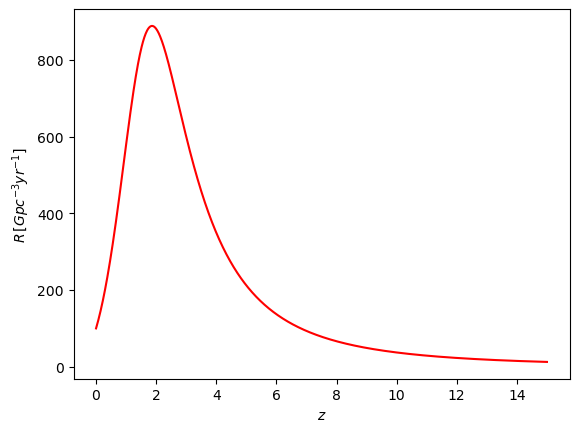

In [7]:
plt.plot(z_, rate_, color='red' )
plt.xlabel(r"$z$")
plt.ylabel(r"$R\,[Gpc^{-3} yr^{-1}]$")
plt.show()

# optical depth
* $\mathcal{D}_c$ : co-moving distance of the source
* as given in equation 18, https://arxiv.org/abs/2204.12977:
$$ \tau(z) = \left(\frac{\mathcal{D}_c(z)}{62.2Gpc}\right)^3 $$

In [8]:
def optical_depth(z):
    # z to luminosity_distance (Dl) conversion
    Dc = Planck18.comoving_distance(z).value*1e-3  # in Gpc
    return( (Dc/62.2)**3 )

In [9]:
opticaldepth = []
z_ = np.linspace(0,5,1000)
for zz in z_:
    opticaldepth.append(optical_depth(zz))
opticaldepth = np.array(opticaldepth)

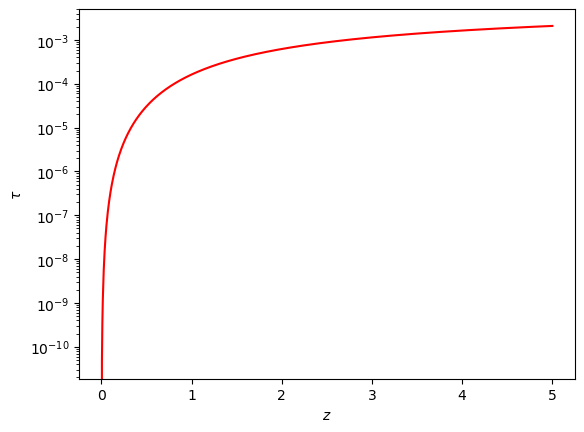

In [10]:
pyplot.plot(z_, opticaldepth, color='red' )
pyplot.yscale('log')
pyplot.xlabel(r"$z$")
pyplot.ylabel(r"$\tau$")
pyplot.show()

# Differential comoving volume element 
* $ \frac{dV_c}{dz} $

In [11]:
# checking units
Planck18.differential_comoving_volume(1)

<Quantity 2.86553105e+10 Mpc3 / sr>

In [12]:
def dVc_dz(z):
    # 4*pi comes from averaging the entire sky
    return(4*np.pi*Planck18.differential_comoving_volume(z).value)*1e-9

# Rate of lensing

$$ R_L = \int_{0}^{\infty}dz \frac{R(z)}{1+z}\tau(z)\frac{dV_c}{dz}\left\{\int_{2}^{\infty}\Theta[D_l(z)<D_{hor}(\mu)] P(\mu) d\mu \right\} $$

In [13]:
def integrand(z, dhor_):
    return( merger_rate_desity(z)/(1+z)*optical_depth(z)*dVc_dz(z)*Bool_lensed(z, dhor_) )

In [14]:
# inetration test for dhor_original=100
quad(integrand, 0, np.inf, args=(100))

(6.609968799396007e-05, 8.600162450035748e-09)

In [15]:
# results with varing Dhor = [20,10000]Mpc

dhor_original = np.linspace(20,10000,20)
R_sl = []
for ii in dhor_original:
    R_sl.append(quad(integrand, 0, np.inf, args=(ii))[0])
    
R_sl = np.array(R_sl)

# Unlensed events' rate

$$ R_U = \int_{0}^{\infty}dz \frac{R(z)}{1+z}\frac{dV_c}{dz} \Theta[D_l(z)<D_{hor}^{original}] $$

In [16]:
def Bool_unlensed(z, dhor_ori):
    
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value #Mpc
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * ((1+z)/(1+z_ori))**(5/6)
    return(int(Dl<dhor))

In [17]:
# test
Bool_unlensed(0.01, 1000)

1

In [18]:
# test
BNSdetection = []
z_ = np.linspace(0,0.2,1000)
for zz in z_:
    BNSdetection.append(Bool_unlensed(zz, 300)) # if dhor = 300Mpc
BNSdetection = np.array(BNSdetection)

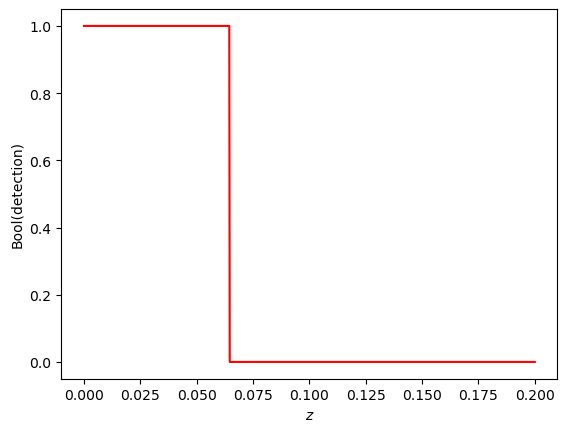

In [19]:
plt.plot(z_, BNSdetection, color='red' )
plt.xlabel(r"$z$")
plt.ylabel(r"Bool(detection)")
plt.show()

In [20]:
def integrand2(z, dhor_):
    return( merger_rate_desity(z)/(1+z)*dVc_dz(z)*Bool_unlensed(z, dhor_) )

In [21]:
quad(integrand2, 0, np.inf, args=(74.8))

(0.1703498884224516, 1.126748491731e-08)

In [22]:
# integration over redshift
dhor_original = np.linspace(20,10000,20)
R_u = []
for ii in dhor_original:
    R_u.append(quad(integrand2, 0, np.inf, args=(ii))[0])
    
R_u = np.array(R_u)

In [23]:
R_u

array([3.32503508e-03, 5.63926019e+01, 3.69925410e+02, 1.08538323e+03,
       2.29118397e+03, 4.04319992e+03, 6.37568711e+03, 9.30715685e+03,
       1.28438757e+04, 1.69821224e+04, 2.17097453e+04, 2.70073135e+04,
       3.28490375e+04, 3.84883529e+04, 4.60346908e+04, 5.33021552e+04,
       6.09622573e+04, 6.89687053e+04, 7.72733378e+04, 8.58269274e+04])

In [24]:
R_sl

array([1.12119183e-07, 4.37051937e-02, 4.85765838e-01, 1.85975897e+00,
       4.61084552e+00, 9.02948478e+00, 1.52507859e+01, 2.32738521e+01,
       3.29874799e+01, 4.41972928e+01, 5.66521841e+01, 7.00688735e+01,
       8.41536970e+01, 9.86209044e+01, 1.13206903e+02, 1.27680179e+02,
       1.41847005e+02, 1.55553359e+02, 1.68683789e+02, 1.81158106e+02])

# relative difference between rate of lensed and unlensed events 

In [25]:
ratio_ = R_sl/R_u
plt.plot(dhor_original, ratio_)
plt.ylabel(r"$ratio=\frac{lensed}{unlensed}$")
plt.xlabel(r"$D_{hor}$[Mpc]")
plt.show()
plt.loglog(dhor_original, ratio_)
plt.ylabel(r"$ratio=\frac{lensed}{unlensed}$")
plt.xlabel(r"$D_{hor}$[Mpc]")
plt.show()

In [26]:
# luminosity distance to redshift
z_hor_ = z_at_value(Planck18.luminosity_distance, dhor_original*u.Mpc).value

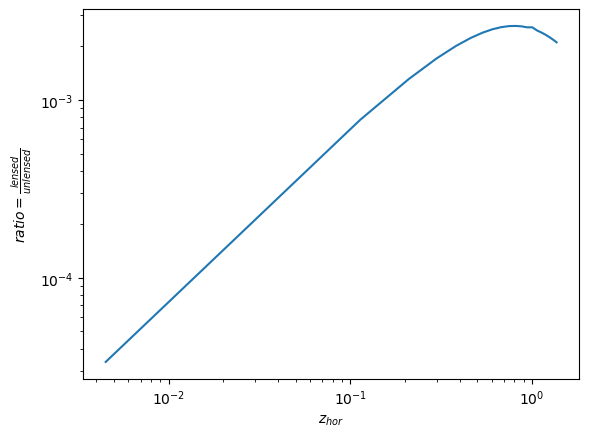

In [27]:
ratio_ = R_sl/R_u
plt.plot(z_hor_, ratio_)
plt.ylabel(r"$ratio=\frac{lensed}{unlensed}$")
plt.xlabel(r"$z_{hor}$")
plt.show()
plt.loglog(z_hor_, ratio_)
plt.ylabel(r"$ratio=\frac{lensed}{unlensed}$")
plt.xlabel(r"$z_{hor}$")
plt.show()